In [1]:
# !git clone https://github.com/mashug0/BAH-ISRO-RCAN
!pip install importlib

In [2]:
import sys
import os
import importlib
# sys.path.append('/kaggle/input/isro-bah-2-files')
# sys.path.append('/kaggle/input/isro-bah-2-files/Data/Data')
sys.path.append('/kaggle/input/bah-train-final')
sys.path.append('/kaggle/input/models-bah')
sys.path.append('/kaggle/input/bah-models-files')
!ls /kaggle/input/bah-models-files/Model

Allignment.py	     fuckit.txt.txt  MainShyt.py	    NoiseEstimator.py
DeformConv2d.py      __init__.py     MultiComponentLoss.py
FeatureExtractor.py  liteRCAN.py     NoiseAwareTDAN.py


In [3]:
import torch
import torch.nn
import torch.nn.functional as F
from Dataset.Degrador import Degrador
from Dataset.CreateDataset import CreateDataset
from Model.MainShyt import RobustLiteDualRCAN
from Model.MultiComponentLoss import MultiComponentLoss

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# hr_count = len(os.listdir("/kaggle/input/isro-bah-2-files/Data/Data/Spacenet/HR"))
# lr1_count = len(os.listdir("/kaggle/input/isro-bah-2-files/Data/Data/Spacenet/LR1"))
# lr2_count = len(os.listdir("/kaggle/input/isro-bah-2-files/Data/Data/Spacenet/LR2"))

# print(f"HR: {hr_count}, LR1: {lr1_count} , LR2: {lr2_count}")
from torchvision import transforms
from PIL import Image
class CreateDataset(Dataset):
    def __init__(self, HR_dir, LR_dir, transform=None):
        self.HR_dir = HR_dir
        self.LR_dir = LR_dir
        self.transform = transform if transform else transforms.ToTensor()
        
        self.hr_files = sorted([
            f for f in os.listdir(self.HR_dir) 
            if f.endswith('.tif')
        ])
        
        # Verify files exist
        self.valid_indices = []
        for idx in range(len(self.hr_files)):
            hr_path = os.path.join(self.HR_dir, self.hr_files[idx])
            lr1_path = os.path.join(self.LR_dir, self.hr_files[idx].replace('.tif', '_0.tif'))
            lr2_path = os.path.join(self.LR_dir, self.hr_files[idx].replace('.tif', '_1.tif'))
            
            if all(os.path.exists(p) for p in [hr_path, lr1_path, lr2_path]):
                self.valid_indices.append(idx)
            else:
                print(f"Missing files for HR: {self.hr_files[idx]}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        hr_path = os.path.join(self.HR_dir, self.hr_files[real_idx])
        lr1_path = os.path.join(self.LR_dir, self.hr_files[real_idx].replace('.tif', '_0.tif'))
        lr2_path = os.path.join(self.LR_dir, self.hr_files[real_idx].replace('.tif', '_1.tif'))

        hr = Image.open(hr_path).convert('L')
        lr1 = Image.open(lr1_path).convert('L')
        lr2 = Image.open(lr2_path).convert('L')

        return {
            'HR': self.transform(hr),
            'LR1': self.transform(lr1),
            'LR2': self.transform(lr2),
            'name': os.path.splitext(self.hr_files[real_idx])[0]
        }

dataset = CreateDataset(
    '/kaggle/input/bah-train-final/BAH/BAH/HR',
    '/kaggle/input/bah-train-final/BAH/BAH/LR',
)

train_len = int(len(dataset) * 0.6)
val_len = int(len(dataset) * 0.3)
test_len = len(dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset,
                                          [train_len, val_len, test_len],
                                          generator=torch.Generator().manual_seed(42))
print(train_len)


6481


In [5]:
!pip install lpips

In [6]:
!pip install torchmetrics sk-video kornia piq

In [7]:
import lpips
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
import torch.nn as nn
import torch
from tqdm import tqdm
from torch.amp import GradScaler,autocast
from kornia.losses import SSIMLoss

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For better error messages

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Try with float32 precision
try:
    lpips_model = lpips.LPIPS(net='alex').float().eval().to(device)
    print("Successfully moved LPIPS to device")
except Exception as e:
    print(f"Error moving to GPU: {e}")
    print("Falling back to CPU")
    lpips_model = lpips.LPIPS(net='alex').float().eval().cpu()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = MultiComponentLoss(perceptual_model=None ,w_ssim=0.3, w_edge=0.05, w_align=0.05, w_perc=0.01).to(device)

# Metrics
def psnr(sr, hr, max_val=1.0):
    mse = torch.mean((sr - hr) ** 2)
    return 10 * torch.log10(max_val ** 2 / mse)

ssim_torch = SSIM().to(device)

def train_epoch_2(model, loader, optimizer):
    model.train()
    total_loss = 0
    # Initialize total_metrics (was missing in original code)
    total_metrics = {"recon": 0.0, "ssim": 0.0, "edge": 0.0, "align": 0.0, "perc": 0.0}

    # Updated AMP syntax for PyTorch 2.0+
    scaler = torch.amp.GradScaler()  # Fixed deprecation warning
    progress_bar = tqdm(loader, desc="Training", leave=False)

    for batch in progress_bar:
        lr1 = batch['LR1'].to(device, non_blocking=True)
        lr2 = batch['LR2'].to(device, non_blocking=True)
        hr = batch['HR'].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        
        # Updated autocast syntax
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):  # Fixed deprecation warning
            # Forward pass
            sr_out, align_loss = model(lr1, lr2)

            # Compute loss & metrics
            loss, batch_metrics = criterion(sr_out, hr, align_loss)
            
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Update totals
        total_loss += loss.item()
        for k in total_metrics:
            total_metrics[k] += batch_metrics[k]

        # Update progress bar
        progress_bar.set_postfix({
            'Total': f"{loss.item():.4f}",
            'Recon': f"{batch_metrics['recon']:.4f}",
            'SSIM': f"{batch_metrics['ssim']:.4f}",
            'Edge': f"{batch_metrics['edge']:.4f}",
            'Align': f"{batch_metrics['align']:.4f}"
        })

    # Calculate averages
    return {
        'total_loss': total_loss / len(loader),
        **{k: v / len(loader) for k, v in total_metrics.items()}
    }



@torch.no_grad()
def validate(model, loader):
    model.eval()
    with torch.cuda.amp.autocast(enabled=False):
        total_psnr = 0
        total_ssim = 0
        total_lpips = 0
    
    # Progress bar
        progress_bar = tqdm(loader, desc="Validation", leave=False)
    
        for batch in progress_bar:
            lr = batch['LR1'].to(device, non_blocking=True)
            lr2 = batch['LR2'].to(device, non_blocking=True)
            hr = batch['HR'].to(device, non_blocking=True)

            sr,_ = model(lr, lr2)
        
        # Calculate metrics
            batch_psnr = psnr(sr, hr)
            batch_ssim = ssim_torch(sr, hr)
            batch_lpips = lpips_model(sr, hr).mean()
        
        # Update totals
            total_psnr += batch_psnr.item()
            total_ssim += batch_ssim.item()
            total_lpips += batch_lpips.item()
        
        # Update progress bar
            progress_bar.set_postfix({
                'PSNR': f"{batch_psnr.item():.2f}",
                'SSIM': f"{batch_ssim.item():.4f}",
                'LPIPS': f"{batch_lpips.item():.4f}"
            })
    
    return {
        'PSNR': total_psnr / len(loader),
        'SSIM': total_ssim / len(loader),
        'LPIPS': total_lpips / len(loader)
    }

Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Successfully moved LPIPS to device


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import math
import torch
import torch.nn.functional as F
from lpips import LPIPS


def visualize_progress(model, dataset,device='cuda', n_samples=1):
    """
    Visualize progress during training (called every 5 epochs)
    
    Args:
        model: Current model state
        dataset: Validation dataset
        epoch: Current epoch number
        device: Device to use
        n_samples: Number of samples to show
    """
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), size=n_samples, replace=False)
    
    with torch.no_grad():
        for idx in indices:
            batch = dataset[idx]
            lr1 = batch['LR1'].unsqueeze(0).to(device)
            lr2 = batch['LR2'].unsqueeze(0).to(device)
            hr = batch['HR'].unsqueeze(0).to(device)
            
            # Generate super-resolved image
            sr,_ = model(lr1, lr2)
            
            # Convert to numpy arrays
            def to_numpy(tensor):
                img = tensor.squeeze().cpu().numpy()
                if img.ndim == 3 and img.shape[0] in [1, 3]:
                    img = img.transpose(1, 2, 0)
                    if img.shape[-1] == 1:
                        img = img.squeeze(-1)
                return np.clip(img, 0, 1)
            
            lr1_np = to_numpy(lr1)
            lr2_np = to_numpy(lr2)
            sr_np = to_numpy(sr)
            hr_np = to_numpy(hr)
            
            # Calculate metrics
            mse = F.mse_loss(sr, hr).item()
            psnr_val = -10 * math.log10(mse) if mse > 0 else float('inf')
            ssim_val = ssim(hr_np, sr_np, data_range=1.0) if hr_np.ndim == 2 else \
                      ssim(hr_np, sr_np, channel_axis=-1, data_range=1.0)
            lpips_val = lpips_model(2*sr-1, 2*hr-1).mean().item()
            
            # Create figure with size ratios
            fig = plt.figure(figsize=(12, 6))
            gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 2, 2])
            
            # Plot LR images (smaller)
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.imshow(lr1_np, cmap='gray' if lr1_np.ndim == 2 else None)
            ax1.set_title(f"LR1 Input\n{lr1_np.shape[:2]}")
            ax1.axis('off')
            
            ax2 = fig.add_subplot(gs[0, 1])
            ax2.imshow(lr2_np, cmap='gray' if lr2_np.ndim == 2 else None)
            ax2.set_title(f"LR2 Input\n{lr2_np.shape[:2]}")
            ax2.axis('off')
            
            # Plot SR and HR (larger)
            ax3 = fig.add_subplot(gs[:, 2])
            ax3.imshow(sr_np, cmap='gray' if sr_np.ndim == 2 else None)
            ax3.set_title(f"SR Output\nPSNR: {psnr_val:.2f} dB\nSSIM: {ssim_val:.4f}\nLPIPS: {lpips_val:.4f}")
            ax3.axis('off')
            
            ax4 = fig.add_subplot(gs[:, 3])
            ax4.imshow(hr_np, cmap='gray' if hr_np.ndim == 2 else None)
            ax4.set_title(f"Ground Truth")
            ax4.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Sample Metrics - PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}, LPIPS: {lpips_val:.4f}")

In [9]:
# !pip install tqdm

from piq import brisque
import numpy as np
import torch # Import torch
from torch.utils.data import DataLoader

def train_model(model ,epochs = 100 , lr = 1e-4 , checkpoint = None):
  train_loader = DataLoader(train_dataset , 
                            batch_size = 8 , 
                            shuffle = True, 
                            pin_memory=True , 
                            num_workers = 2,
                            persistent_workers=True,
                            prefetch_factor=6
)
  val_loader = DataLoader(val_dataset , 
                          batch_size = 8, 
                          shuffle = True,
                          pin_memory=True,
                          num_workers = 2,
                         persistent_workers=True,
                         prefetch_factor=4
                         )

  optimizer = torch.optim.Adam(model.parameters() , lr = lr)
  if checkpoint is not None:
    checkpoint_weight = torch.load(checkpoint)
    optimizer.load_state_dict(checkpoint_weight['optimizer_state_dict'])
    starting_epoch = checkpoint_weight['epoch'] + 1
  else:
    starting_epoch = 1
        
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , 'max' , patience = 5)
    
  best_psnr = 0
  for epoch in range(starting_epoch,epochs):
      
    train_loss = train_epoch_2(model, train_loader, optimizer)
    metrics = validate(model, val_loader)
    scheduler.step(metrics['PSNR'])

    if metrics['PSNR'] > best_psnr:
        best_psnr = metrics['PSNR']
        torch.save(model.state_dict(), 'best_model.pth')
        torch

        # Consistent logging with lowercase keys
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss['total_loss']:.4f} | "
          f"SSIM Loss: {train_loss['ssim']:.4f} | "  # Lowercase 'ssim'
          f"L1 Loss: {train_loss['recon']:.4f} | "   # 'recon' instead of 'Recon'
          f"Edge Loss: {train_loss['edge']:.4f} | "
          f"Alignment Loss: {train_loss['align']:.4f} | "
          f"Val PSNR: {metrics['PSNR']:.2f} dB | "
          f"SSIM: {metrics['SSIM']:.4f} | "
          f"LPIPS: {metrics['LPIPS']:.4f}")

    # blind_test(model , val_loader)
    if epoch%1==0:
      visualize_progress(model , test_dataset , device = device)
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, f"checkpoint_epoch_{epoch+1}.pth")


def blind_test(model , loader):
  niqe_scores = []
  model.eval()
  with torch.no_grad():
    for i, batch in enumerate(loader):
      lr = batch['LR1'].to(device)
      lr2 = batch['LR2'].to(device)
      hr = batch['HR'].to(device)

      sr = model(lr , lr2).cpu()
      # Handle grayscale vs color for BRISQUE calculation
      sr_np = sr.squeeze().cpu().numpy()
      if sr_np.ndim == 3 and sr_np.shape[0] in [1, 3]:
          sr_np = sr_np.transpose(1, 2, 0)
          if sr_np.shape[-1] == 1:
              sr_np = sr_np.squeeze(-1)

      # Ensure numpy array is in the correct format for brisque (H, W) or (H, W, C)
      if sr_np.ndim == 2:
          niqe_scores.append(brisque(torch.from_numpy(sr_np).unsqueeze(0).unsqueeze(0))) # Add batch and channel dim for piq
      elif sr_np.ndim == 3:
           niqe_scores.append(brisque(torch.from_numpy(sr_np).permute(2,0,1).unsqueeze(0))) # Permute to C, H, W and add batch dim for piq


  print(f"Average BRISQUE: {np.mean([score.item() for score in niqe_scores])}") # Extract scalar values from tensors

In [10]:
%%javascript
// Keeps Kaggle session alive by simulating activity every 5 mins
function keepAlive() {
    console.log("Keeping session alive");
    document.querySelector('body').click();  // Simulate a click
}
setInterval(keepAlive, 5 * 60 * 1000);  // Run every 5 minutes

<IPython.core.display.Javascript object>

/tmp/ipykernel_134/1615227307.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Epoch 99/100 | Train Loss: 0.0424 | SSIM Loss: 0.0483 | L1 Loss: 0.0263 | Edge Loss: 0.0251 | Alignment Loss: 0.0065 | Val PSNR: 29.03 dB | SSIM: 0.9212 | LPIPS: 0.0713


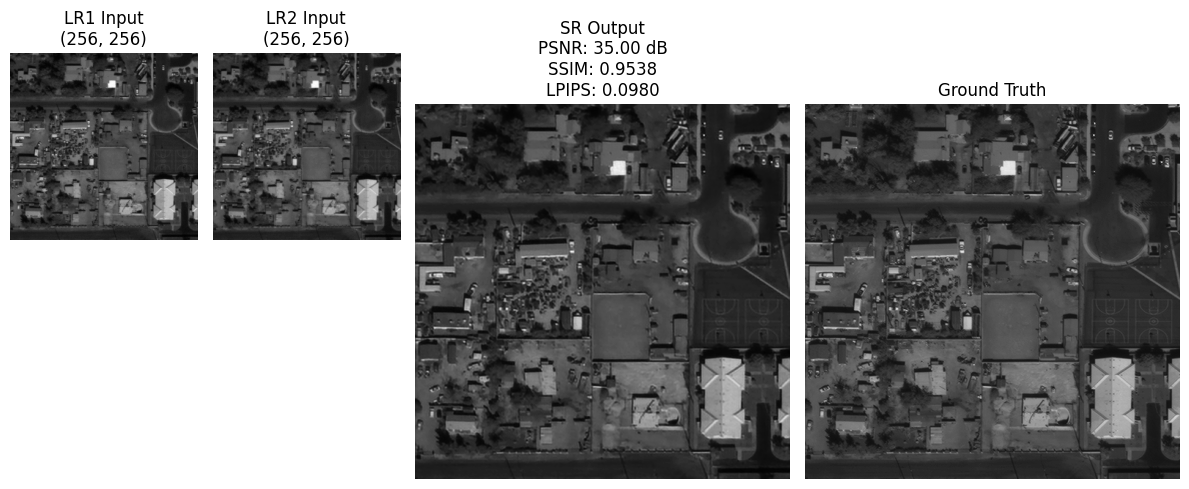

Sample Metrics - PSNR: 35.00 dB, SSIM: 0.9538, LPIPS: 0.0980


Epoch 100/100 | Train Loss: 0.0423 | SSIM Loss: 0.0483 | L1 Loss: 0.0263 | Edge Loss: 0.0251 | Alignment Loss: 0.0064 | Val PSNR: 29.11 dB | SSIM: 0.9213 | LPIPS: 0.0713


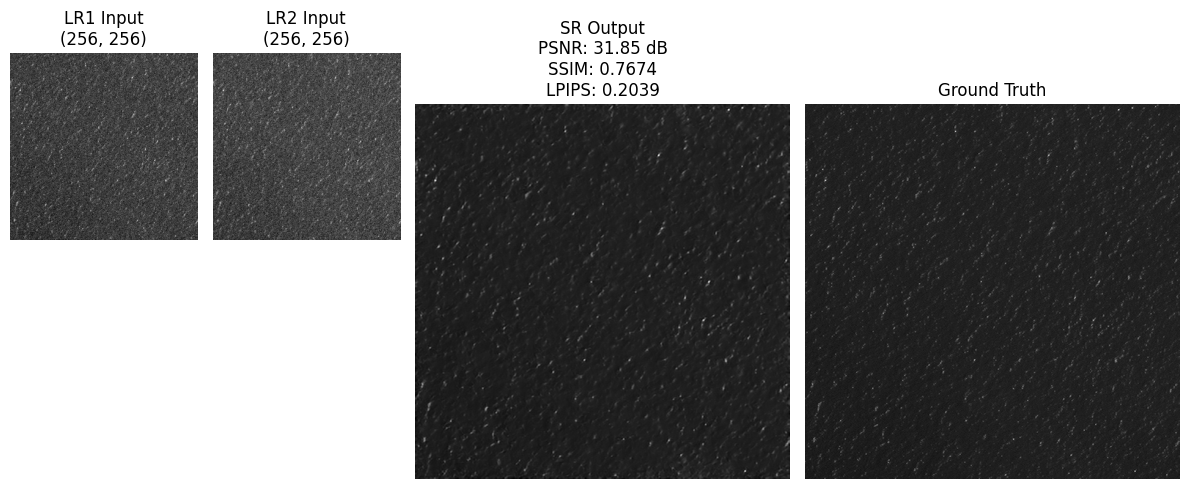

Sample Metrics - PSNR: 31.85 dB, SSIM: 0.7674, LPIPS: 0.2039


In [11]:
from importlib import reload
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch

torch.backends.cudnn.benchmark = True
model = RobustLiteDualRCAN(in_channels = 1 , n_features = 32 , n_rg = 5 , n_rcab = 5 , scale =2).to(device)
model.load_state_dict(torch.load('/kaggle/input/models-bah/best_model_4.pth'))

train_model(model , checkpoint = '/kaggle/input/models-bah/checkpoint_epoch_98.pth' )

In [13]:
visualize_progress(model,train_dataset,5)

RuntimeError: CUDA error: invalid device ordinal
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
